In [2]:
from langgraph.graph import StateGraph, END
import random
from typing import TypedDict, List, Dict

In [4]:
class AgentState(TypedDict):
    name : str
    number : List[int]
    counter: int

In [29]:
def greeting_node(state: AgentState) -> AgentState:
    """Greeting Node which says hi to the person"""

    state['name'] = f"hi there, {state['name']}"
    state['counter'] = 0
    state['number'] = []
    return state

def random_node(state: AgentState) -> AgentState:
    """Generates a random number from 0 to 10"""

    state['number'].append(random.randint(0,10))
    state['counter'] +=1
    return state


In [30]:
def should_continue(state: AgentState) -> AgentState:
    """Function to decide what to do next"""
    if state["counter"] < 5:
        print("ENTERING LOOP", state["counter"])
        return "loop"  # Continue looping
    else:
        return "exit"  # Exit the loop

In [31]:
graph = StateGraph(AgentState)

graph.set_entry_point("greeting")

graph.add_node("greeting", greeting_node)
graph.add_node("random", random_node)



graph.add_edge("greeting", "random")

graph.add_conditional_edges(
    "random",
    should_continue,
    {"loop":"random",
     "exit": END}
)
app = graph.compile()

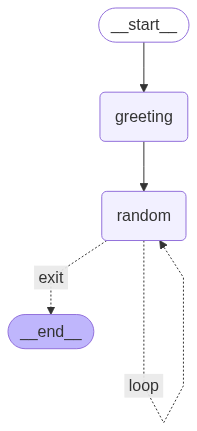

In [32]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [34]:
app.invoke({'name': 'john'})

ENTERING LOOP 1
ENTERING LOOP 2
ENTERING LOOP 3
ENTERING LOOP 4


{'name': 'hi there, john', 'number': [0, 0, 4, 4, 6], 'counter': 5}

# Exercise

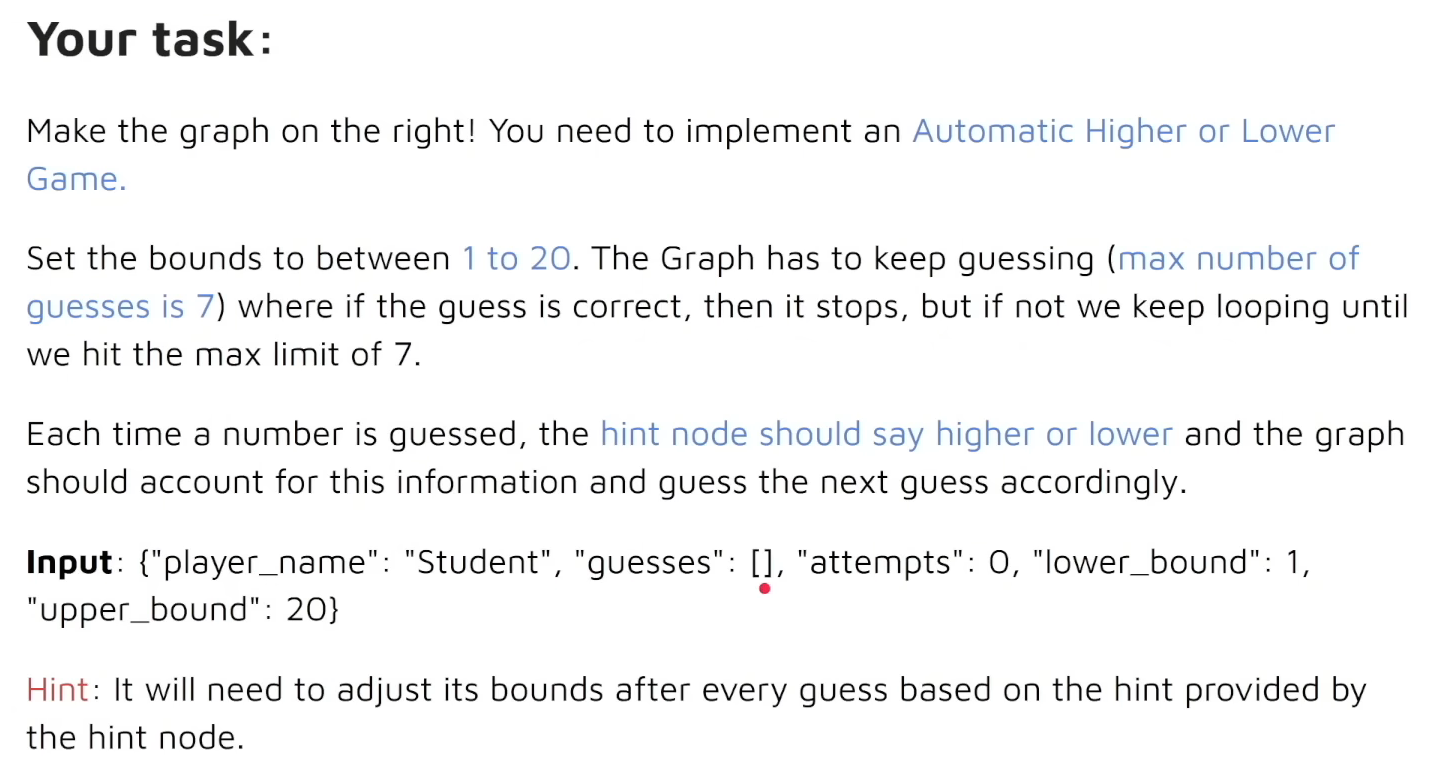

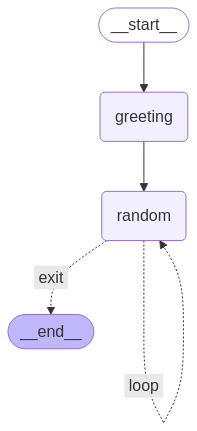

In [35]:
from langgraph.graph import StateGraph, END
import random
from typing import TypedDict, List, Dict

In [45]:
class GameState(TypedDict):
    player_name: str
    target_number: int
    guesses: List[int]
    attempts: int
    hint: str
    lower_bound: int 
    upper_bound: int 

In [46]:
def setup_node(state: GameState) -> GameState:
    """Initialize the game with a random target number"""
    
    state["player_name"] = f"Welcome, {state['player_name']}!"
    state["target_number"] = random.randint(1, 20)
    state["guesses"] = []
    state["attempts"] = 0
    state["hint"] = "Game started! Try to guess the number."
    state["lower_bound"] = 1 
    state["upper_bound"] = 20 
    print(f"{state['player_name']} The game has begun. I'm thinking of a number between 1 and 20.")
    return state

In [ ]:
def guess_node(state: GameState) -> GameState:
    """Generate a smarter guess based on previous hints"""
    
    possible_guesses = [i for i in range(state["lower_bound"], state["upper_bound"] + 1) if i not in state["guesses"]]
    
    if possible_guesses:
        guess = random.choice(possible_guesses)
    else:
        
        guess = random.randint(state["lower_bound"], state["upper_bound"])
    
    state["guesses"].append(guess)
    state["attempts"] += 1
    print(f"Attempt {state['attempts']}: Guessing {guess} (Current range: {state['lower_bound']}-{state['upper_bound']})")
    return state

In [ ]:
def hint_node(state: GameState) -> GameState:
    """Here we provide a hint based on the last guess and update the bounds"""
    latest_guess = state["guesses"][-1]
    target = state["target_number"]
    
    if latest_guess < target:
        state["hint"] = f"The number {latest_guess} is too low. Try higher!"
        
        state["lower_bound"] = max(state["lower_bound"], latest_guess + 1)
        print(f"Hint: {state['hint']}")
        
    elif latest_guess > target:
        state["hint"] = f"The number {latest_guess} is too high. Try lower!"
      
        state["upper_bound"] = min(state["upper_bound"], latest_guess - 1)
        print(f"Hint: {state['hint']}")
    else:
        state["hint"] = f"Correct! You found the number {target} in {state['attempts']} attempts."
        print(f"Success! {state['hint']}")
    
    return state

In [49]:
def should_continue(state: GameState) -> str:
    """Determine if we should continue guessing or end the game"""
    
    # There are 2 end conditions - either 7 is reached or the correct number is guessed
    
    latest_guess = state["guesses"][-1]
    if latest_guess == state["target_number"]:
        print(f"GAME OVER: Number found!")
        return "end"
    elif state["attempts"] >= 7:
        print(f"GAME OVER: Maximum attempts reached! The number was {state['target_number']}")
        return "end"
    else:
        print(f"CONTINUING: {state['attempts']}/7 attempts used")
        return "continue"

In [50]:
graph = StateGraph(GameState)
graph.add_node("setup", setup_node)
graph.add_node("guess", guess_node)
graph.add_node("hint_node", hint_node)  


graph.add_edge("setup", "guess")
graph.add_edge("guess", "hint_node")  


graph.add_conditional_edges(
    "hint_node", 
    should_continue,
    {
        "continue": "guess",
        "end": END
    }
)

graph.set_entry_point("setup")
app = graph.compile()

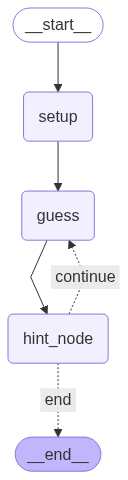

In [51]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [52]:
result = app.invoke({"player_name": "Student", "guesses": [], "attempts": 0, "lower_bound": 1, "upper_bound": 20})

Welcome, Student! The game has begun. I'm thinking of a number between 1 and 20.
Attempt 1: Guessing 19 (Current range: 1-20)
Hint: The number 19 is too high. Try lower!
CONTINUING: 1/7 attempts used
Attempt 2: Guessing 11 (Current range: 1-18)
Hint: The number 11 is too high. Try lower!
CONTINUING: 2/7 attempts used
Attempt 3: Guessing 6 (Current range: 1-10)
Hint: The number 6 is too low. Try higher!
CONTINUING: 3/7 attempts used
Attempt 4: Guessing 9 (Current range: 7-10)
Hint: The number 9 is too high. Try lower!
CONTINUING: 4/7 attempts used
Attempt 5: Guessing 7 (Current range: 7-8)
Hint: The number 7 is too low. Try higher!
CONTINUING: 5/7 attempts used
Attempt 6: Guessing 8 (Current range: 8-8)
Success! Correct! You found the number 8 in 6 attempts.
GAME OVER: Number found!


In [55]:
result = app.invoke({"player_name": "Cody"})

Welcome, Cody! The game has begun. I'm thinking of a number between 1 and 20.
Attempt 1: Guessing 14 (Current range: 1-20)
Hint: The number 14 is too high. Try lower!
CONTINUING: 1/7 attempts used
Attempt 2: Guessing 4 (Current range: 1-13)
Hint: The number 4 is too low. Try higher!
CONTINUING: 2/7 attempts used
Attempt 3: Guessing 10 (Current range: 5-13)
Hint: The number 10 is too high. Try lower!
CONTINUING: 3/7 attempts used
Attempt 4: Guessing 7 (Current range: 5-9)
Hint: The number 7 is too high. Try lower!
CONTINUING: 4/7 attempts used
Attempt 5: Guessing 5 (Current range: 5-6)
Hint: The number 5 is too low. Try higher!
CONTINUING: 5/7 attempts used
Attempt 6: Guessing 6 (Current range: 6-6)
Success! Correct! You found the number 6 in 6 attempts.
GAME OVER: Number found!
